In [2]:
import pydicom
import pydicom.pixels
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import time

In [3]:
images_path="rsna-breast-cancer-detection"
train_csv_path=os.path.join(images_path,"train.csv")

In [4]:
train_csv = pd.read_csv(train_csv_path)
train_csv.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True


In [5]:
def load_dcim_image(image_path):
    dcim = pydicom.dcmread(image_path)
    return dcim.pixel_array

[ 29  21 216  93  49  48 170 210 190 197]


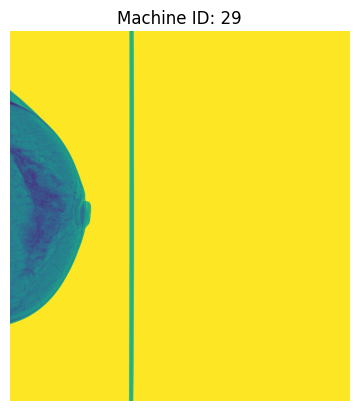

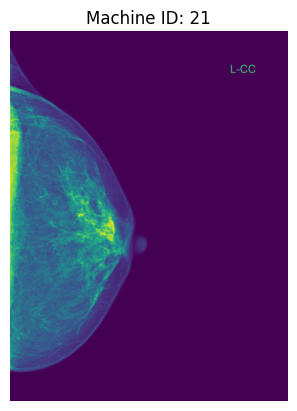

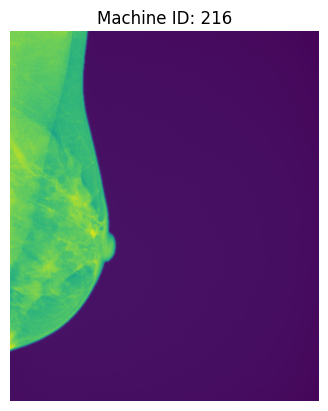

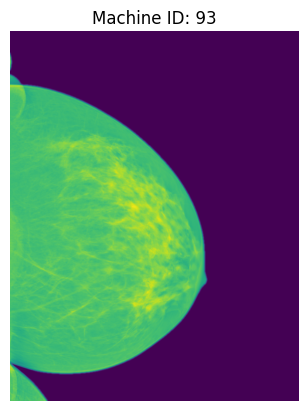

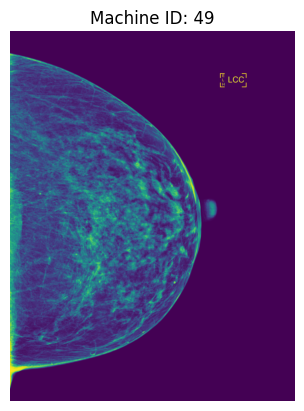

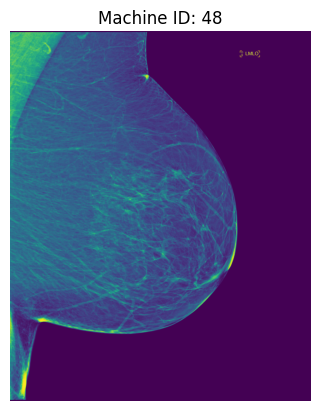

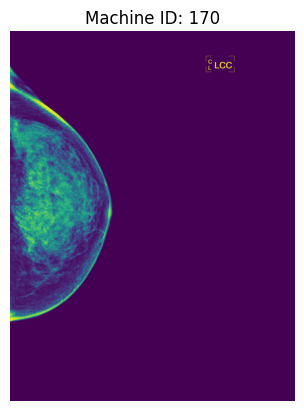

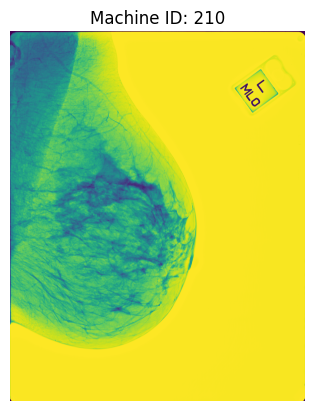

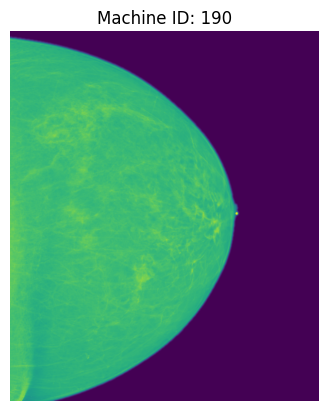

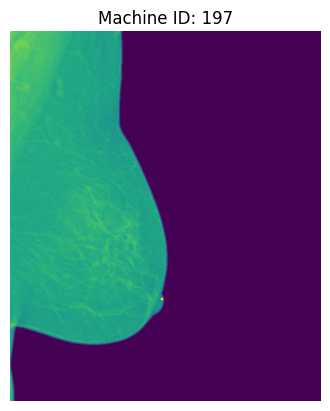

In [6]:
# Find all the machine_ids
machine_ids = train_csv["machine_id"].unique()
print(machine_ids)

machine_rows = []

# Visualize the first image of each machine_id
for machine_id in machine_ids:
    row = train_csv[train_csv["machine_id"] == machine_id].iloc[0]
    machine_rows.append(row)
    image_id = row["image_id"]
    patient_id = row["patient_id"]
    image_path = os.path.join(images_path, "train_images", str(patient_id), str(image_id) + ".dcm")
    image = load_dcim_image(image_path)
    plt.imshow(image)
    plt.title(f"Machine ID: {machine_id}")
    plt.axis("off")
    plt.show()

In [ ]:

def create_average_kernel(size):
    return np.ones(size) / size

def find_breast(image):
    new_image = image.copy()

    # Ensure the image is in 8-bit grayscale format
    if len(image.shape) == 3:
        new_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    elif image.dtype != np.uint8:
        new_image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    
    # Step 1: Apply Gaussian blur to reduce noise
    blurred_image = cv2.GaussianBlur(new_image, (5, 5), 0)
    
    # Step 2: Use adaptive thresholding to create a binary mask
    binary_mask = cv2.threshold(blurred_image, 20, 255, cv2.THRESH_BINARY)[1]
    
    # Step 3: Find the largest connected component
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_mask, connectivity=8)
    
    largest_component = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
    
    # Get the bounding box of the largest component
    x, y, w, h = stats[largest_component, cv2.CC_STAT_LEFT], stats[largest_component, cv2.CC_STAT_TOP], \
                 stats[largest_component, cv2.CC_STAT_WIDTH], stats[largest_component, cv2.CC_STAT_HEIGHT]
    
    
    return (x, y, w, h)

# Example usage
# image = cv2.imread('path_to_image', cv2.IMREAD_GRAYSCALE)
# breast_image = find_breast(image)
# cv2.imshow('Breast Image', breast_image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [39]:
def invert_if_needed(image):
    image = image - np.min(image)
    if np.sum(image == np.max(image)) > np.sum(image == np.min(image)):
        return invert_image(image)
    return image

def remove_borders(image):
    # Check if there are borders (lines of maximum intensity) on the image
    row_mean = np.mean(image, axis=1)
    col_mean = np.mean(image, axis=0)
    
    max_value = np.max(image) - 5
    
    row_max_count = np.sum(row_mean >= max_value)
    col_max_count = np.sum(col_mean >= max_value)
    
    row_min_count = np.sum(row_mean == 0)
    col_min_count = np.sum(col_mean == 0)
    
    row_start = 0
    row_end = image.shape[0]
    col_start = 0
    col_end = image.shape[1]
    
    if row_max_count > 0:
        row_indices = np.where(row_mean < max_value)[0]
        row_start = row_indices[0]
        row_end = row_indices[-1]
    if col_max_count > 0:
        col_indices = np.where(col_mean < max_value)[0]
        col_start = col_indices[0]
        col_end = col_indices[-1]
        
        
    if row_min_count > 0:
        row_indices = np.where(row_mean > 0)[0]
        row_start = max(row_start, row_indices[0])
        row_end = min(row_end, row_indices[-1])
        
    if col_min_count > 0:
        col_indices = np.where(col_mean > 0)[0]
        col_start = max(col_start, col_indices[0])
        col_end = min(col_end, col_indices[-1])
    
    return image[row_start:row_end, col_start:col_end]

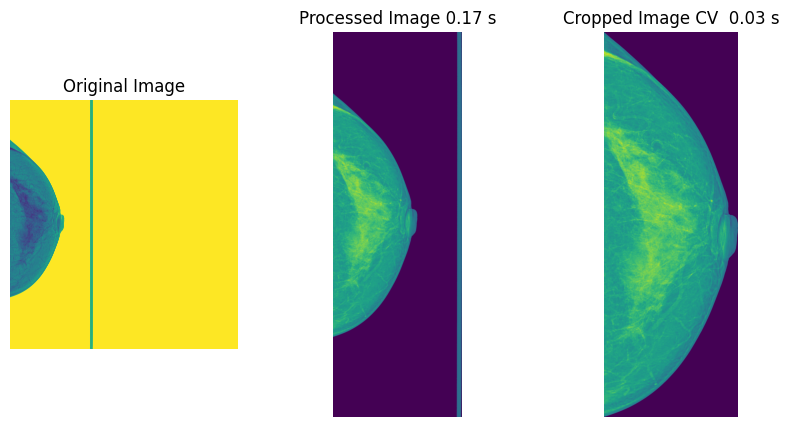

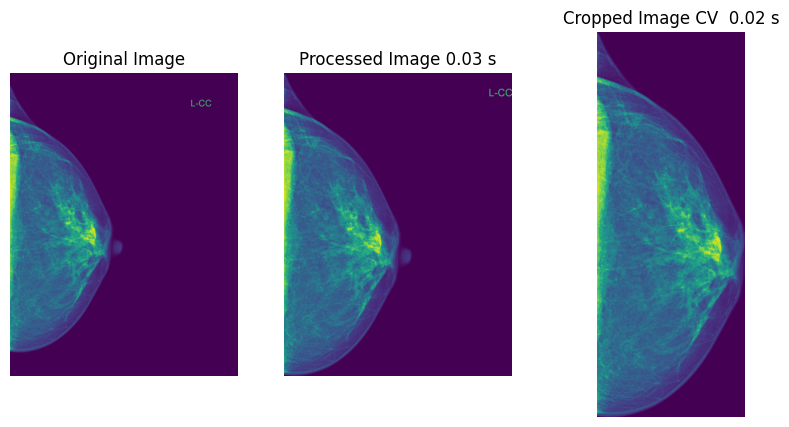

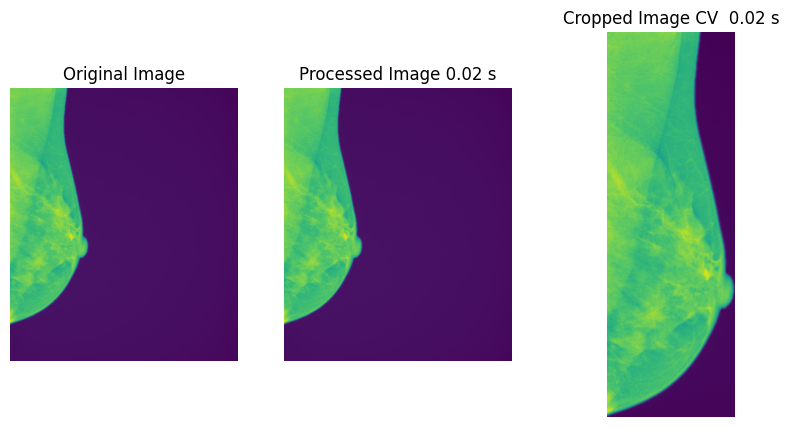

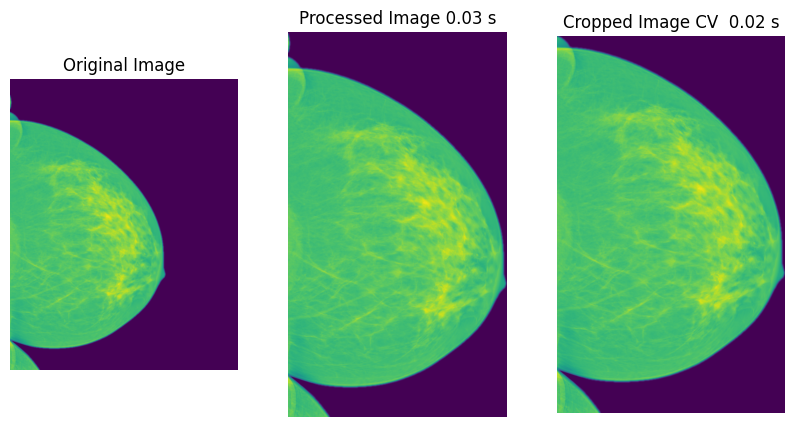

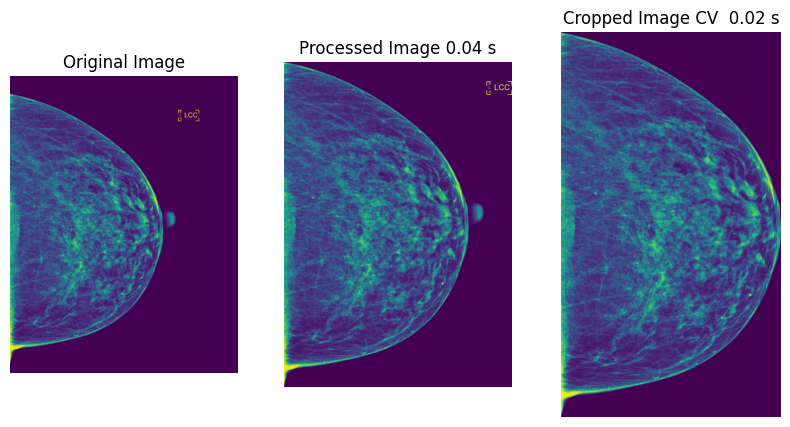

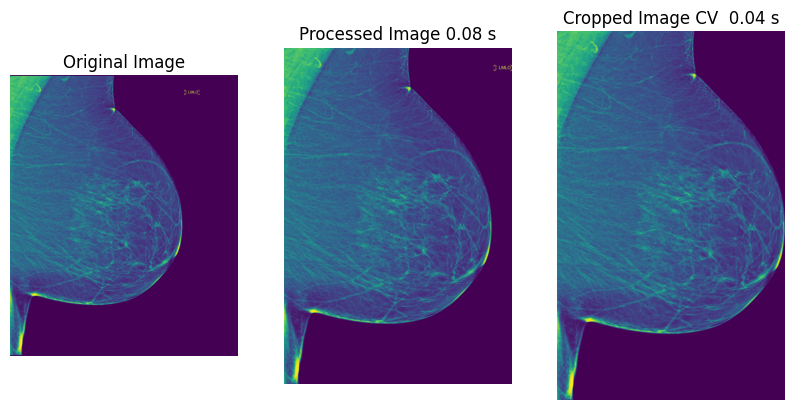

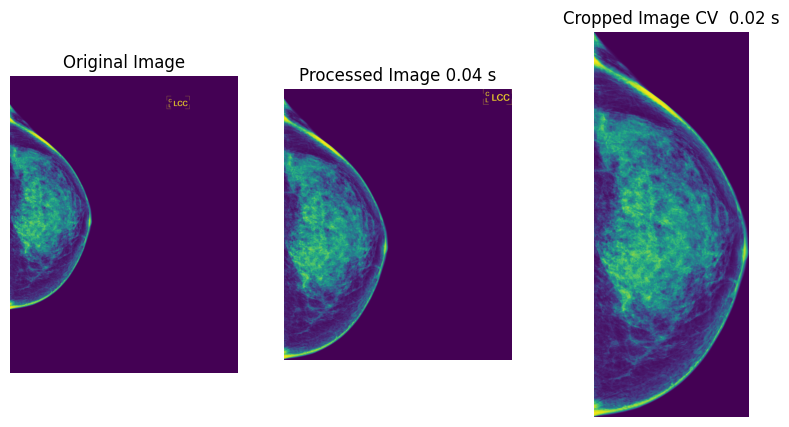

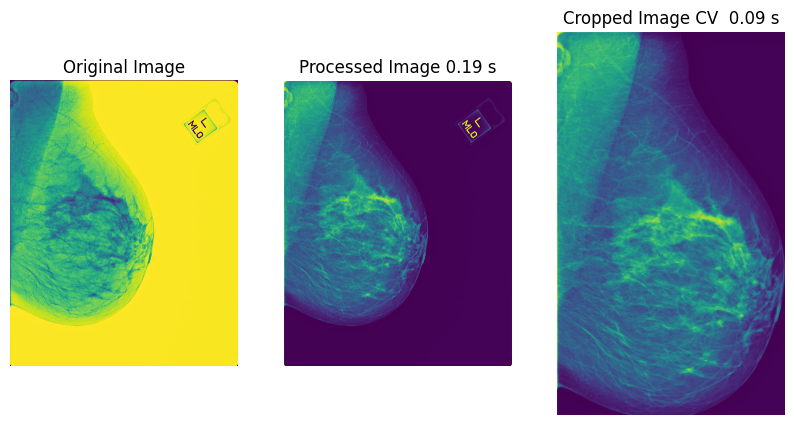

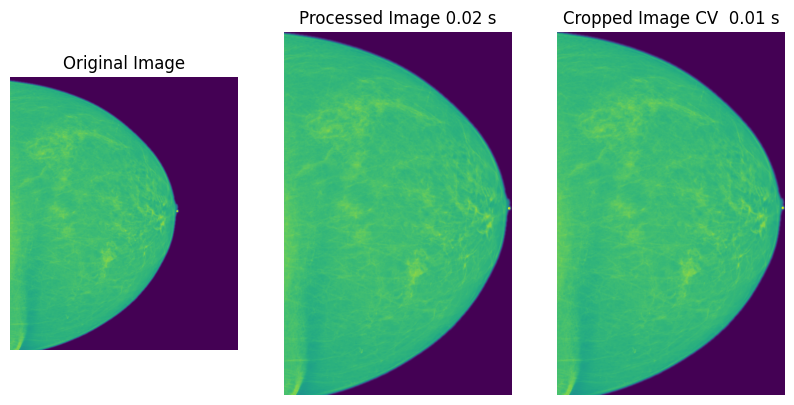

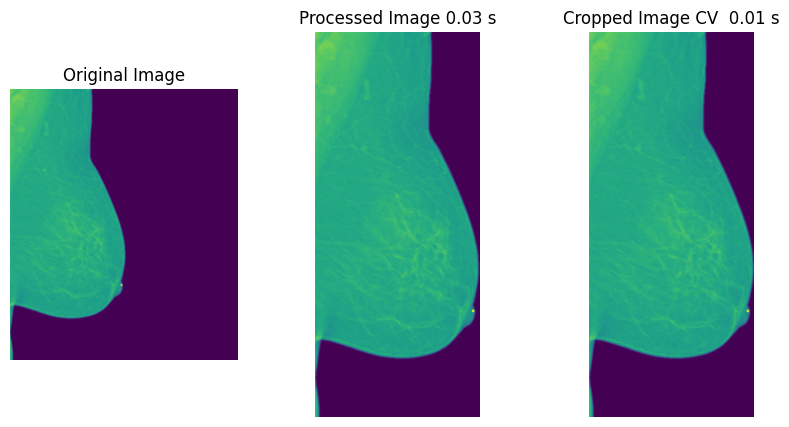

In [41]:
# test the cropping on the rows from machine_rows
i = 0
for row in machine_rows:
    image_id = row["image_id"]
    patient_id = row["patient_id"]
    image_path = os.path.join(images_path, "train_images", str(patient_id), str(image_id) + ".dcm")
    org_image = load_dcim_image(image_path)
    
    #If the image is inverted, invert it back
    # Check by looking at the number of max and min values
    start_time = time.time()
    image = invert_if_needed(org_image)
    image = remove_borders(image)
    processing_time = time.time() - start_time
    brest_image_cv = find_breast(image)
    find_breast_time = time.time() - processing_time - start_time
    
    i += 1
    
    # Show the original and cropped images
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(org_image)
    plt.title("Original Image")
    plt.axis("off")
    plt.subplot(1, 3, 2)
    plt.imshow(image)
    plt.title("Processed Image" + (f" {processing_time:.2f} s"))
    plt.axis("off")
    plt.subplot(1, 3, 3)
    plt.imshow(brest_image_cv)
    plt.title("Cropped Image CV " + (f" {find_breast_time:.2f} s"))
    plt.axis("off")
    plt.show()